In [51]:
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt

# for plotting consistently with abu_profile
from nugridpy import utils as u

# use h5py to read and write h5 file
import h5py

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [52]:
# get mesa data
star2 = ms.star_log(mass=2.0,Z=0.02)
star3 = ms.star_log(mass=3.0,Z=0.02)

# get post processing data
star2_pp = mp.se(mass=2.0,Z=0.02)
star3_pp = mp.se(mass=3.0,Z=0.02)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Using old star.logsa file ...
 reading ...100% 

Closing star.log  tool ...
nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 3.0
Using old star.logsa file ...
 reading ...100% 

Closing star.log  tool ...
nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Searching files, please wait.......
Reading preprocessor files
File search complete.
Closing plot_tools
nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 3.0
Searching files, please wait.......
Reading preprocessor files
File search complete.Closing plot_tools



## Useful functions

In [53]:
# function to find the maximum extent of convection zone as well as the average extent

def mass_bounds(star,model_range):
    # just need the star objects, and the model range that the convection zone is contained in

    # get the mass ranges of convection boundary
    star_mass = star.get('star_mass')[model_range[0]:model_range[1]]
    mix_low = star.get('mx2_bot')[model_range[0]:model_range[1]]
    mix_high = star.get('mx2_top')[model_range[0]:model_range[1]]
    
    # find where they are zero or not
    convection_bounds = []
    for i in range(len(star_mass) - 1):
        
        # make sure that there is convection and that the next element doesnt stop
        if mix_low[i] >= 1e-9 and mix_low[i+1] >= 1e-9:
            convection_bounds.append(i)
            
    # slice the arrays to the appropriate size
    star_mass = star_mass[convection_bounds[0]:(convection_bounds[-1] + 1)]
    mix_low = mix_low[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    mix_high = mix_high[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    
    # make sure that if there
    
    # return the max convection bounds as well as average AND new model range
    max_bounds = [min(mix_low),max(mix_high)]
    avg_bounds = [np.mean(mix_low),np.mean(mix_high)]
    model_range = [int(model_range[0] + convection_bounds[0]), int(model_range[0] + convection_bounds[-1])]
    
    # NOTE model_range is an index and NOT a model number!
    return max_bounds,avg_bounds, model_range
    
# function to find the nearest mass element index to a particular mass
def find_mass_index(star_pp,model,mass_interest):
    
    # check if model is a list of multiple stars to look through
    if type(model) == float or type(model) == int:
        model = [model]
        iterate = len(model)
    else:
        iterate = len(model)
    
    # check if mass interest is a list or not
    mass_bool = 0
    if type(mass_interest) == float or type(mass_interest) == int:
        mass_bool = 0
    else:
        mass_bool = 1 
    
    # create a np array to hold the mass index
    mass_index = np.zeros((iterate))
    
    # iterate through
    for i in range(iterate):
        
        # read in the mass array
        mass = star_pp.se.get(int(model[i]),'mass')
        
        # is mass interest a list
        if mass_bool:
            mass_index[i] = int(np.argmin(abs(mass_interest[i] - mass)))
        else:
            mass_index[i] = int(np.argmin(abs(mass_interest[i] - mass)))
    
    # return the mass index array
    return mass_index

Make a log dt vs model number plot with temperature at the bottom of the convection zone to see how these temperatures vary. It was seen that in the M=2 models, log T ~ 8.4 was when the Ne-22 reaction really kicked off but it was at a time step that was ~ 10 years in length (can't resolve convection time scale)

## Mass = 2M$_{\odot}$

In [54]:
# Thermal pulse of interest is at model numbers..
model_range = [53000,54000]

# find the convection model number range
mass_b,mass_b1,conv_bounds = mass_bounds(star2,model_range)

# conv bounds ARE MODEL NUMBERS, need index for slicing

# get the log dt, model numbers, and bottom convection boundary for convection boundaries
log_dt = star2.get('log_dt')[conv_bounds[0]:conv_bounds[1]]
model_number = star2.get('model_number')[conv_bounds[0]:conv_bounds[1]]
mx_bot = star2.get('mx2_bot')[conv_bounds[0]:conv_bounds[1]] * star2.get('star_mass')[conv_bounds[0]:conv_bounds[1]]

# find the bottom convection zone bass index
mass_index = find_mass_index(star2_pp,model_number,mx_bot)

 reading ['mass']...100%

In [55]:
# find the temperature for each model number AT convective boundary
temperature = []

for i in range(len(mass_index)):
    
    # read in the temperature
    temp = star2_pp.get(int(model_number[i]),'temperature')
    
    # get the temperature at mass index, append
    temperature.append(temp[int(mass_index[i])] * 1e9)

 reading ['temperature']...100%

In [56]:
star10 = ms.star_log(mass=25.0,Z=0.02)
time = star10.get('star_age')[-1]

# sum all  dts, assume years
time_dt = star10.get('log_dt')
time_dt = 10**(time_dt)
print(np.sum(time_dt))
print(time)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 25.0
Using old star.logsa file ...
 reading ...100% 

Closing star.log  tool ...
7579485.96472
7579485.96472


<IPython.core.display.Javascript object>


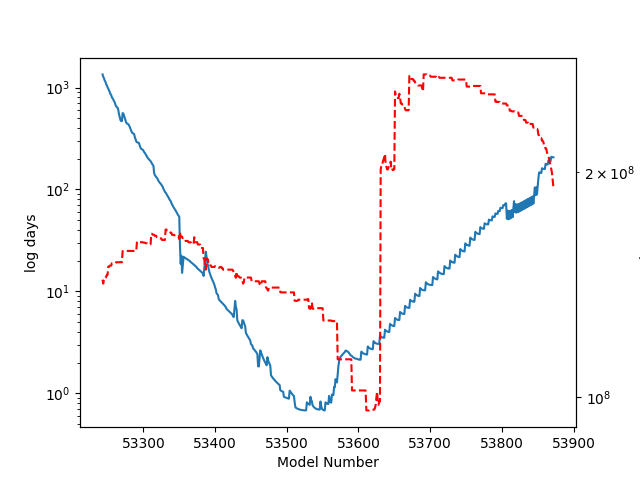

In [57]:
# make a plot of log dt and temperature
fig = plt.figure(1)
ax1 = fig.add_subplot(111)

# plot log dt first
ax1.plot(model_number,10**(log_dt) * 365.25)

# log y axis
ax1.semilogy()
ax1.set_ylabel('log days')
ax1.set_xlabel('Model Number')

# make second but with temperature
ax2 = ax1.twinx()

# plot temperature
ax2.plot(model_number,temperature,'r--')

# log y axis
ax2.semilogy()
ax2.set_ylabel('log T')

#### Convective Time Scale

In [58]:
# grab the .se.h5 files containing the data needed
path_file = '/data/nugrid_apod2/data/set1ext/set1.2/see_wind/M2.00Z2.0e-02/M2.00Z0.020/M2.00Z0.020.0053001.se.h5'

data_file = h5py.File(path_file)

# model number
model = 53590

# cycle to work with is at highest T, 53700
data_group = data_file['cycle00000'+str(model)]['SE_DATASET']

In [59]:
# print out data type
print(data_group.dtype)

[('mass', '<f8'), ('delta_mass', '<f8'), ('radius', '<f8'), ('rho', '<f8'), ('temperature', '<f8'), ('dcoeff', '<f8'), ('convection_indicator', '<i4'), ('yps', '<f8', (6,)), ('pressure', '<f8'), ('eps_grav', '<f8'), ('eps_nuc', '<f8'), ('velocity', '<f8')]


In [60]:
# need mass, pressure, radius and dcoeff
mass = np.flip(data_group['mass'],0)
pressure = np.flip(data_group['pressure'],0)
radius = np.flip(data_group['radius'],0)
diffusion = np.flip(data_group['dcoeff'],0)
temperature_h5 = np.flip(data_group['temperature'],0)

# get the mixing ranges
mx_bot = star2.get('mx2_bot')[model-1] * star2.get('star_mass')[model-1]
mx_top = star2.get('mx2_top')[model-1] * star2.get('star_mass')[model-1]

# get dt in minutes
time_min = 10**(star2.get('log_dt')[model-1]) * 365.25 * 24 * 60

# find the index number for the mass
bot_index = int(find_mass_index(star2_pp,model,[mx_bot])[0])
top_index = int(find_mass_index(star2_pp,model,[mx_top])[0])

# the mixing length is alpha * scale height at bottom of convection
alpha = 1.73
Hp = - pressure[bot_index] * (radius[bot_index + 1] - radius[bot_index]) / (pressure[bot_index + 1] - pressure[bot_index])
mixing_length = alpha * Hp

# get the actual extent of the convection zone in Hp
r_conv = (radius[top_index] - radius[bot_index]) * alpha / (mixing_length)
print('\n')
print('The number of pressure scale heights in the convection zone is',r_conv)

# the convective velocity
vmlt = np.median(3 * diffusion[bot_index:(top_index + 1)] / mixing_length)

# print the convective time in minutes
print('The convective time scale in hours using MLT',mixing_length/vmlt / 60. )
print('The convective time scale in absolute time hours is',(r_conv *mixing_length / alpha) / vmlt / 60.)
print('The number of sub time steps needed MLT is',time_min / (mixing_length/vmlt ) )
print('The number of sub time steps needed non-MLT is',time_min / ((r_conv *mixing_length / alpha) / vmlt / 60.))

 reading ['mass']...100%

The number of pressure scale heights in the convection zone is 15.2865765206
The convective time scale in hours using MLT 3.79499386698
The convective time scale in absolute time hours is 33.5332162675
The number of sub time steps needed MLT is 14.7720792179
The number of sub time steps needed non-MLT is 100.306423793


Take a look at the temperature profile for some of the higher temperatures, schwarz boundary could be at a lower temperature than further up

<IPython.core.display.Javascript object>


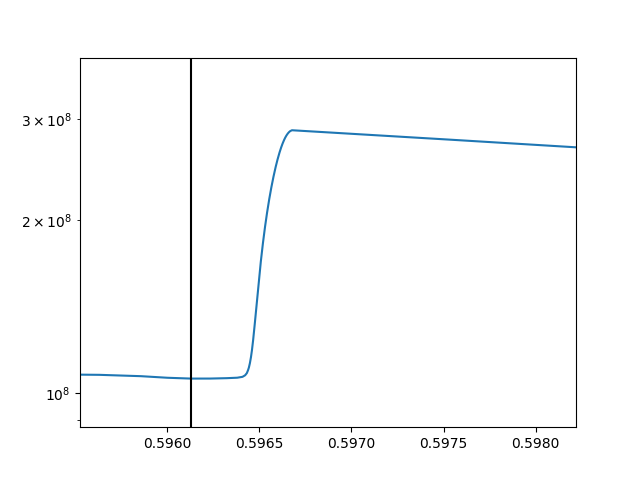

(10000000.0, 500000000.0)

In [15]:
# use the temperature profile from model number 53700
fig = plt.figure(182)
ax = fig.add_subplot(111)

# plot T as a function of mass, use schwarz bounds
ax.plot(mass,temperature_h5)

# logy
ax.semilogy()

# add schwarz boundaries
ax.axvline(mass[bot_index],color='k',linestyle='-')
ax.axvline(mass[top_index],color='k',linestyle='-')

# set limits
ax.set_xlim([0.595,0.618])
ax.set_ylim([1e7,5e8])

## Mass = 3M$_{\odot}$

In [40]:
# Thermal pulse of interest is at model numbers..
model_range = [58000,60000]

# find the convection model number range
mass_b,mass_b1,conv_bounds = mass_bounds(star3,model_range)

# conv bounds ARE MODEL NUMBERS, need index for slicing

# get the log dt, model numbers, and bottom convection boundary for convection boundaries
log_dt = star3.get('log_dt')[conv_bounds[0]:conv_bounds[1]]
model_number = star3.get('model_number')[conv_bounds[0]:conv_bounds[1]]
mx_bot = star3.get('mx2_bot')[conv_bounds[0]:conv_bounds[1]] * star3.get('star_mass')[conv_bounds[0]:conv_bounds[1]]

# find the bottom convection zone bass index
mass_index = find_mass_index(star3_pp,model_number,mx_bot)

 reading ['mass']...100%

In [41]:
# find the temperature for each model number AT convective boundary
temperature = []

for i in range(len(mass_index)):
    
    # read in the temperature
    temp = star3_pp.get(int(model_number[i]),'temperature')
    
    # get the temperature at mass index, append
    temperature.append(temp[int(mass_index[i])] * 1e9)

 reading ['temperature']...100%

<IPython.core.display.Javascript object>


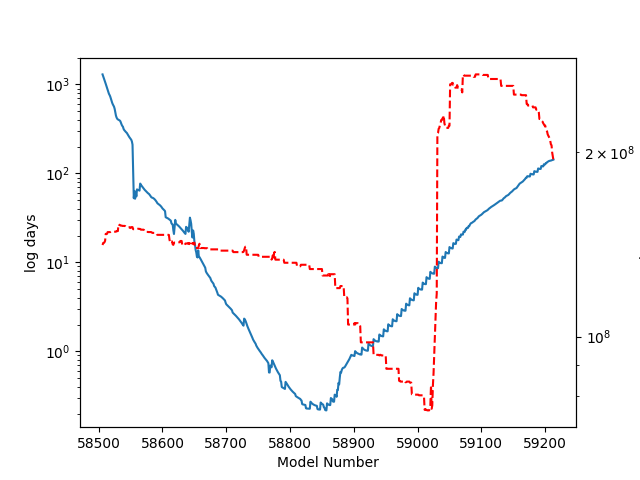

In [42]:
# make a plot of log dt and temperature
fig = plt.figure(2)
ax1 = fig.add_subplot(111)

# plot log dt first
ax1.plot(model_number,10**(log_dt) * 365.25)

# log y axis
ax1.semilogy()
ax1.set_ylabel('log days')
ax1.set_xlabel('Model Number')

# make second but with temperature
ax2 = ax1.twinx()

# plot temperature
ax2.plot(model_number,temperature,'r--')

# log y axis
ax2.semilogy()
ax2.set_ylabel('log T')

Read in the h5 file from nugrid data set to see if the temperature gradient at the highest temperature at schwarz is indeed the highest temperature.

In [48]:
# grab the .se.h5 files containing the data needed
path_file = '/data/nugrid_apod2/data/set1ext/set1.2/see_wind/M3.00Z2.0e-02/M3.00Z0.020/M3.00Z0.020.0059001.se.h5'

data_file = h5py.File(path_file)

# model number
model = 59200

# cycle to work with is at highest T, 53700
data_group = data_file['cycle00000'+str(model)]['SE_DATASET']

In [49]:
# need mass, pressure, radius and dcoeff
mass = np.flip(data_group['mass'],0)
pressure = np.flip(data_group['pressure'],0)
radius = np.flip(data_group['radius'],0)
diffusion = np.flip(data_group['dcoeff'],0)
temperature_h5 = np.flip(data_group['temperature'],0)

# get the mixing ranges
mx_bot = star3.get('mx2_bot')[model-1] * star3.get('star_mass')[model-1]
mx_top = star3.get('mx2_top')[model-1] * star3.get('star_mass')[model-1]

# find the index number for the mass
bot_index = int(find_mass_index(star3_pp,model,[mx_bot])[0])
top_index = int(find_mass_index(star3_pp,model,[mx_top])[0])

# get dt in minutes
time_min = 10**(star3.get('log_dt')[model-1]) * 365.25 * 24 * 60

# find the index number for the mass
bot_index = int(find_mass_index(star3_pp,model,[mx_bot])[0])
top_index = int(find_mass_index(star3_pp,model,[mx_top])[0])

# the mixing length is alpha * scale height at bottom of convection
alpha = 1.73
Hp = - pressure[bot_index] * (radius[bot_index + 1] - radius[bot_index]) / (pressure[bot_index + 1] - pressure[bot_index])
mixing_length = alpha * Hp

# get the actual extent of the convection zone in Hp
r_conv = (radius[top_index] - radius[bot_index]) * alpha / (mixing_length)
print('\n')
print('The number of pressure scale heights in the convection zone is',r_conv)

# the convective velocity
vmlt = np.median(3 * diffusion[bot_index:(top_index + 1)] / mixing_length)

# print the convective time in minutes
print('The convective time scale in hours using MLT',mixing_length/vmlt / 60. )
print('The convective time scale in absolute time hours is',(r_conv *mixing_length / alpha) / vmlt / 60.)
print('The number of sub time steps needed MLT is',time_min / (mixing_length/vmlt ) )
print('The number of sub time steps needed non-MLT is',time_min / ((r_conv *mixing_length / alpha) / vmlt / 60.))

 reading ['mass']...100%

The number of pressure scale heights in the convection zone is 2.6499248905
The convective time scale in hours using MLT 409.430348318
The convective time scale in absolute time hours is 627.14431846
The number of sub time steps needed MLT is 7.4091202572
The number of sub time steps needed non-MLT is 290.222068351


In [ ]:
# use the temperature profile from model number 53700
fig = plt.figure(183)
ax = fig.add_subplot(111)

# plot T as a function of mass, use schwarz bounds
ax.plot(mass,temperature_h5)

# logy
ax.semilogy()

# add schwarz boundaries
ax.axvline(mass[bot_index],color='k',linestyle='-')
ax.axvline(mass[top_index],color='k',linestyle='-')

# set limits
# ax.set_xlim([0.595,0.618])
# ax.set_ylim([1e7,5e8])